In [22]:
# @title 1. Ignore Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning, module='jupyter_client.session')

In [23]:
# @title 2. Installs & Setup
!pip install -q pandas numpy scikit-learn sentence-transformers umap-learn matplotlib seaborn mlxtend networkx plotly

In [24]:
# @title 3. Imports
import os
import re
import json
import math
import itertools
import ast
from pathlib import Path
from collections import Counter

# Core Libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

# Embedding
from sentence_transformers import SentenceTransformer

# Dimensionality Reduction
import umap

# Association Rule Mining
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px  # For interactive plots
import plotly.io as pio
pio.templates.default = "plotly_white"

sns.set(style='whitegrid')
print("Imports complete.")

Imports complete.


In [25]:
# @title 4. Phase 1: Configuration (Using Nomic-Embed)

#Project Paths
try:
    from google.colab import drive
    print("🔗 Mounting Google Drive…")
    drive.mount('/content/drive')
    # Set your project directory in Google Drive
    PROJECT_DIR = Path('/content/drive/MyDrive/hashtag_project/')
except Exception:
    print("⚠️ Not running on Google Colab. Using local directory './hashtag_project/'.")
    PROJECT_DIR = Path('./hashtag_project/')

OUTPUT_DIR = PROJECT_DIR / 'outputs/'
# dataset: https://www.kaggle.com/datasets/tariqsays/chatgpt-twitter-dataset
DATASET_PATH = PROJECT_DIR / 'chatgpt1.csv'

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"📁 Project Directory: {PROJECT_DIR}")
print(f"📁 Output Directory: {OUTPUT_DIR}")


# Model Parameters
# Embedding model (sentence-transformers)
EMBED_MODEL = 'nomic-ai/nomic-embed-text-v1.5'
EMBED_BATCH_SIZE = 32

# Scope Reduction
TOP_N_TRENDS = 10

UMAP_COMPONENTS = 10 # Reduce to 10 dimensions for DBSCAN

# DBSCAN params
DBSCAN_EPS = 0.5
DBSCAN_MIN_SAMPLES = 15

# Apriori params (for co-occurrence rules)
MIN_SUPPORT = 0.01         # A hashtag set must appear in at least 1% of a cluster's posts
MIN_CONFIDENCE = 0.5       # 50% of the time 'A' appears, 'B' must also appear
MIN_LIFT = 1.2             # The co-occurrence is at least 20% more likely than random chance

# Visualization params
UMAP_N_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1
TOP_N_CLUSTERS_TO_VISUALIZE = 5 # For the per-cluster hashtag plots

🔗 Mounting Google Drive…
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Project Directory: /content/drive/MyDrive/hashtag_project
📁 Output Directory: /content/drive/MyDrive/hashtag_project/outputs


In [26]:
# @title 5. Phase 2: Data Loading & Preprocessing (Utility Functions) [FIXED]

# --- Regex for cleaning ---
HASHTAG_RE = re.compile(r"#(\w+)")
URL_RE = re.compile(r'https?://\S+')
MENTION_RE = re.compile(r'@\w+')

def clean_text(text):
    """Removes URLs, mentions, and extra whitespace from text."""
    if not isinstance(text, str):
        return ''
    t = URL_RE.sub('', text)
    t = MENTION_RE.sub('', t)
    # remove hashtags from text, as we have them separately
    t = HASHTAG_RE.sub('', t)
    # remove non-ASCII (emojis, etc.)
    t = re.sub(r'[^\x00-\x7F]+', ' ', t)
    # remove extra whitespace
    t = re.sub(r'\s+', ' ', t).strip()
    return t

def extract_hashtags_from_text(text):
    """Finds all hashtags in a text and returns a list of tags (without '#')."""
    if not isinstance(text, str):
        return []
    # Return *just* the tag text, no '#'
    return [m.group(1).lower() for m in HASHTAG_RE.finditer(text)]

def normalize_hashtag_list(hlist):
    """
    Takes various inputs (list, str-list, str) and returns a
    clean, sorted list of hashtags (e.g., ['#ai', '#chatgpt']).
    """
    tags_to_clean = []

    if isinstance(hlist, list):
        tags_to_clean = [str(item) for item in hlist if item]

    #  Check for string
    elif isinstance(hlist, str):
        if hlist.startswith('[') and hlist.endswith(']'):
            try:
                eval_list = ast.literal_eval(hlist)
                if isinstance(eval_list, list):
                    tags_to_clean = [str(item) for item in eval_list]
            except (ValueError, SyntaxError):
                pass

        if not tags_to_clean:
            tags_from_re = [m.group(1) for m in HASHTAG_RE.finditer(hlist)]
            if tags_from_re:
                tags_to_clean = tags_from_re
            else:
                # Fallback: split on commas or spaces
                tokens = re.split(r'[,;\s]+', hlist.strip())
                tags_to_clean = [tok for tok in tokens if tok]

    elif pd.isna(hlist):
        return []


    clean_tags = set()
    for t in tags_to_clean:
        # remove #, spaces, lowercase, and ensure alphanumeric
        t_cleaned = str(t).strip().lower().lstrip('#')
        if t_cleaned and re.match(r'^\w+$', t_cleaned):
            clean_tags.add('#' + t_cleaned)  # Add '#' back consistently

    return sorted(list(clean_tags))

def extract_hashtags_row(row, text_col, hashtags_col):
    """
    Robustly extracts hashtags for a single DataFrame row.
    1. Tries the dedicated `hashtags_col` first.
    2. If empty, falls back to extracting from the `text_col`.
    """
    # 1. dedicated 'hashtag' column first
    if hashtags_col and pd.notna(row[hashtags_col]):
        tags = normalize_hashtag_list(row[hashtags_col])
        if tags:  # found tags, return them
            return tags

    # If 'hashtag' column was empty or missing, extract from 'text'
    if text_col and pd.notna(row[text_col]):
        # This path calls extract_hashtags_from_text, which returns a list.
        # The corrected normalize_hashtag_list can now handle this.
        return normalize_hashtag_list(extract_hashtags_from_text(row[text_col]))

    return []

print("Utility functions defined.")

Utility functions defined.


In [27]:
# @title 6. Phase 2: Load & Process Dataset [UPDATED FOR SCOPE]
print('Loading dataset from', DATASET_PATH)
if not Path(DATASET_PATH).exists():
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}. Please upload it.")

# Load only the columns we absolutely need to save RAM
try:
    raw_df = pd.read_csv(DATASET_PATH, dtype=str, low_memory=False, usecols=['Text', 'hashtag'])
    text_col = 'Text'
    hashtags_col = 'hashtag'
except ValueError:
    raw_df = pd.read_csv(DATASET_PATH, dtype=str, low_memory=False)
    text_col = 'Text'
    hashtags_col = 'hashtag'

print(f'Loaded {len(raw_df)} raw rows.')
print(f"Using Text Column: '{text_col}'")
print(f"Using Hashtag Column: '{hashtags_col}'")

# --- Create Working DataFrame ---
df = pd.DataFrame()
df['text'] = raw_df[text_col].fillna('').astype(str)
df['raw_hashtags'] = raw_df[hashtags_col].fillna('').astype(str)
del raw_df # Free up RAM

# --- 1. Extract Hashtags (Robustly) ---
print('Extracting hashtags from all rows...')
df['hashtags'] = df.apply(
    extract_hashtags_row,
    axis=1,
    text_col='text',
    hashtags_col='raw_hashtags'
)

# --- 2. CRITICAL FILTER (for Apriori) ---
# Keep only tweets with 2 or more hashtags for co-occurrence analysis.
initial_count = len(df)
df = df[df['hashtags'].map(len) > 1].reset_index(drop=True)
print(f"Filtered {initial_count} -> {len(df)} tweets (kept posts with >= 2 hashtags).")

if len(df) < 100:
    print("WARNING: Very few tweets (<<100) have 2+ hashtags. Halting.")
    raise SystemExit("Not enough data for Apriori analysis.")

# --- 3. NEW: SCOPE REDUCTION (To save RAM) ---
print(f"Reducing scope to Top {TOP_N_TRENDS} trends...")
all_tags_list = list(itertools.chain.from_iterable(df['hashtags'].tolist()))
all_tags_counts = Counter(all_tags_list)

# Find the main query hashtag (e.g., #chatgpt) to EXCLUDE it
main_query_tag = all_tags_counts.most_common(1)[0][0]
print(f"Main query tag is '{main_query_tag}'. It will be excluded from topic trends.")

# Get the Top N *topical* hashtags (excluding the main one)
top_trends = set()
for tag, count in all_tags_counts.most_common(TOP_N_TRENDS + 1):
    if tag != main_query_tag:
        top_trends.add(tag)
    if len(top_trends) == TOP_N_TRENDS:
        break

print(f"Identified Top {len(top_trends)} topical hashtags: {top_trends}")

# Filter the DataFrame to only include posts that contain AT LEAST ONE of these trends
df['has_top_trend'] = df['hashtags'].apply(lambda tags: any(t in top_trends for t in tags))

scoped_count = len(df)
df = df[df['has_top_trend']].reset_index(drop=True)
print(f"Filtered {scoped_count} -> {len(df)} tweets (posts must contain a top 10 trend).")

if len(df) < 100:
    print("WARNING: Very few tweets (<<100) match top trends. Halting.")
    raise SystemExit("Not enough data after scope reduction.")

# --- 4. Clean Text for Embedding ---
print('Cleaning text for embeddings...')
df['clean_text'] = df['text'].apply(clean_text)

# --- 5. Preview Top Hashtags (in the NEW scoped dataset) ---
print('\n--- Top 20 Hashtags in FINAL SCOPED Dataset ---')
all_scoped_tags = list(itertools.chain.from_iterable(df['hashtags'].tolist()))
for tag, cnt in Counter(all_scoped_tags).most_common(20):
    print(f"{tag}: {cnt}")

# Save the processed data
processed_csv = OUTPUT_DIR / 'processed_tweets_scoped.csv'
df[['clean_text', 'hashtags', 'text']].to_csv(processed_csv, index=False)
print(f"\nSaved processed data to {processed_csv}")

Loading dataset from /content/drive/MyDrive/hashtag_project/chatgpt1.csv
Loaded 50001 raw rows.
Using Text Column: 'Text'
Using Hashtag Column: 'hashtag'
Extracting hashtags from all rows...
Filtered 50001 -> 7542 tweets (kept posts with >= 2 hashtags).
Reducing scope to Top 10 trends...
Main query tag is '#chatgpt'. It will be excluded from topic trends.
Identified Top 10 topical hashtags: {'#ai', '#machinelearning', '#chatgpt3', '#microsoft', '#technology', '#ia', '#google', '#tech', '#openai', '#artificialintelligence'}
Filtered 7542 -> 4062 tweets (posts must contain a top 10 trend).
Cleaning text for embeddings...

--- Top 20 Hashtags in FINAL SCOPED Dataset ---
#chatgpt: 3204
#ai: 2387
#openai: 971
#artificialintelligence: 685
#microsoft: 458
#technology: 289
#google: 264
#ia: 255
#machinelearning: 252
#tech: 228
#chatgpt3: 199
#deeplearning: 113
#openaichatgpt: 101
#datascience: 99
#cybersecurity: 97
#chatbot: 96
#technews: 85
#ml: 80
#gpt3: 79
#bigdata: 78

Saved processed data

In [28]:
# @title 7. Phase 3: Text Embedding (Using Nomic-Embed)
print('Loading embedding model:', EMBED_MODEL)
# Note: trust_remote_code=True is required for the nomic-ai model
model = SentenceTransformer(EMBED_MODEL, trust_remote_code=True)

# Get list of texts to embed
texts_to_embed = df['clean_text'].tolist()

if not texts_to_embed:
    raise ValueError("No texts to embed. Check Phase 2 for errors (e.g., all posts were filtered out).")

print(f'Encoding {len(texts_to_embed)} texts... (This may take a while)')
embeddings = model.encode(
    texts_to_embed,
    batch_size=EMBED_BATCH_SIZE,
    show_progress_bar=True
)
embeddings = np.array(embeddings)

# Normalize embeddings for cosine distance (good practice for SBERT)
embeddings = normalize(embeddings)
print('Embeddings shape:', embeddings.shape)

# Save embeddings
np.save(OUTPUT_DIR / 'embeddings.npy', embeddings)
print(f"Saved embeddings to {OUTPUT_DIR / 'embeddings.npy'}")

# Define our feature matrix X
X = embeddings

Loading embedding model: nomic-ai/nomic-embed-text-v1.5


Encoding 4062 texts... (This may take a while)


Batches:   0%|          | 0/127 [00:00<?, ?it/s]

Embeddings shape: (4062, 768)
Saved embeddings to /content/drive/MyDrive/hashtag_project/outputs/embeddings.npy


In [29]:
# @title 8. Phase 3.5: Dimensionality Reduction for Clustering
print(f"Original embeddings shape: {X.shape}")
print(f"Running UMAP to reduce dimensions (e.g., {X.shape[1]} -> {UMAP_COMPONENTS}) for DBSCAN...")

# reduce to {UMAP_COMPONENTS} dimensions for clustering.
# different from the 2D UMAP for visualization later.
umap_cluster_reducer = umap.UMAP(
    n_neighbors=UMAP_N_NEIGHBORS, # From config
    min_dist=UMAP_MIN_DIST,     # From config
    n_components=UMAP_COMPONENTS,
    random_state=42,
    metric='cosine' #  'cosine' here as the input (X) is normalized
)

# new data we will use for clustering
X_cluster = umap_cluster_reducer.fit_transform(X)

print(f"New shape for clustering: {X_cluster.shape}")

Original embeddings shape: (4062, 768)
Running UMAP to reduce dimensions (e.g., 768 -> 10) for DBSCAN...
New shape for clustering: (4062, 10)


Calculating k-distance graph for k=15 to find optimal eps...
Running NearestNeighbors on 10-dim UMAP data (metric=euclidean)...
Saved k-distance plot to /content/drive/MyDrive/hashtag_project/outputs/k_distance_plot.png


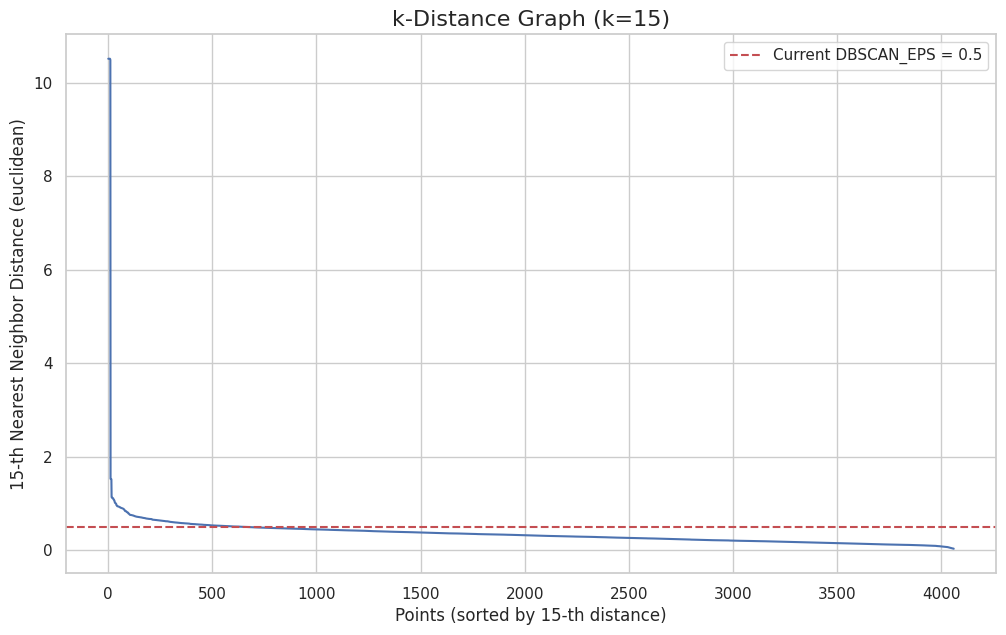

---
‼️ ACTION: Look at the new plot. Find the 'elbow' (the point of maximum curvature).
The Y-axis value at this 'elbow' is your new ideal `DBSCAN_EPS`.
Update `DBSCAN_EPS` in Cell 4 (Configuration) to this value and re-run from Cell 10.
---


In [30]:
# @title 9. Phase 4: DBSCAN Tuning (k-Distance Plot)
# Find optimal EPS using a k-distance graph
print(f"Calculating k-distance graph for k={DBSCAN_MIN_SAMPLES} to find optimal eps...")

print(f"Running NearestNeighbors on {X_cluster.shape[1]}-dim UMAP data (metric=euclidean)...")
# Use 'euclidean' distance on the new UMAP data
neighbors = NearestNeighbors(n_neighbors=DBSCAN_MIN_SAMPLES, metric='euclidean')
neighbors_fit = neighbors.fit(X_cluster)
distances, indices = neighbors_fit.kneighbors(X_cluster)

k_distances = sorted(distances[:, DBSCAN_MIN_SAMPLES-1], reverse=True)

# --- Plot the graph ---
plt.figure(figsize=(12, 7))
plt.plot(k_distances)
plt.title(f'k-Distance Graph (k={DBSCAN_MIN_SAMPLES})', fontsize=16)
plt.xlabel(f'Points (sorted by {DBSCAN_MIN_SAMPLES}-th distance)', fontsize=12)
plt.ylabel(f'{DBSCAN_MIN_SAMPLES}-th Nearest Neighbor Distance (euclidean)', fontsize=12)
plt.grid(True)

plt.axhline(y=DBSCAN_EPS, color='r', linestyle='--', label=f'Current DBSCAN_EPS = {DBSCAN_EPS}')
plt.legend()

kdist_file = OUTPUT_DIR / 'k_distance_plot.png'
plt.savefig(kdist_file)
print(f"Saved k-distance plot to {kdist_file}")
plt.show()

print("---")
print("‼️ ACTION: Look at the new plot. Find the 'elbow' (the point of maximum curvature).")
print("The Y-axis value at this 'elbow' is your new ideal `DBSCAN_EPS`.")
print(f"Update `DBSCAN_EPS` in Cell 4 (Configuration) to this value and re-run from Cell 10.")
print("---")

In [31]:
# @title 10. Phase 4: Run DBSCAN Clustering [UPDATED]
print(f'Running DBSCAN with eps={DBSCAN_EPS} and min_samples={DBSCAN_MIN_SAMPLES}')

cl = DBSCAN(
    eps=DBSCAN_EPS,
    min_samples=DBSCAN_MIN_SAMPLES,
    metric='euclidean',
    n_jobs=-1
)
labels = cl.fit_predict(X_cluster)

df['cluster'] = labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = sum(labels == -1)

print(f'\n--- Clustering Results ---')
print(f'Clusters found (excluding noise): {n_clusters}')
print(f'Noise points (cluster -1): {n_noise} / {len(df)} ({(n_noise/len(df))*100:.1f}%)')

clustered_csv = OUTPUT_DIR / 'clustered_tweets.csv'
df.to_csv(clustered_csv, index=False)
print(f'\nSaved clustered data to {clustered_csv}')

cluster_sizes = df.groupby('cluster').size().sort_values(ascending=False)
print('\n--- Cluster Sizes (Top 20) ---')
print(cluster_sizes.head(20))

Running DBSCAN with eps=0.5 and min_samples=15

--- Clustering Results ---
Clusters found (excluding noise): 16
Noise points (cluster -1): 204 / 4062 (5.0%)

Saved clustered data to /content/drive/MyDrive/hashtag_project/outputs/clustered_tweets.csv

--- Cluster Sizes (Top 20) ---
cluster
 0     2037
 8      443
 2      219
 1      215
 5      206
-1      204
 3      204
 9      136
 7      124
 6      101
 4       48
 12      28
 13      22
 10      21
 14      19
 15      19
 11      16
dtype: int64


In [32]:
# @title 11. Phase 5: Visualization (Interactive UMAP)
print('Computing UMAP for 2D interactive visualization...')

# --- We run UMAP *again*, this time just for 2D visualization ---
# We use the *original* high-dimensional embeddings (X) for this,
# as it often gives a richer 2D map.
umap_vis_reducer = umap.UMAP(
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    n_components=2,
    random_state=42,
    metric='cosine'
)
X_2d = umap_vis_reducer.fit_transform(X)

# Create the visualization dataframe
vis_df = pd.DataFrame({'x': X_2d[:,0], 'y': X_2d[:,1]})
vis_df['cluster'] = df['cluster'].values
vis_df['cluster_str'] = 'Cluster ' + vis_df['cluster'].astype(str)
vis_df.loc[vis_df['cluster'] == -1, 'cluster_str'] = 'Noise'
vis_df['text'] = df['clean_text'].values
vis_df['hashtags'] = df['hashtags'].apply(', '.join).values

print(f"Created visualization dataframe with {len(vis_df)} points.")

# --- Create Plot ---
fig = px.scatter(
    vis_df,
    x='x',
    y='y',
    color='cluster_str',
    color_discrete_map={'Noise': 'lightgray'},
    hover_data={
        'x': False, # hide x-coord
        'y': False, # hide y-coord
        'cluster_str': True,
        'text': True,
        'hashtags': True
    },
    title='Interactive UMAP of Tweet Clusters'
)

fig.update_layout(
    legend_title_text='Cluster',
    xaxis_title='UMAP-1',
    yaxis_title='UMAP-2'
)
fig.update_traces(marker=dict(size=5, opacity=0.8))

umap_html_file = OUTPUT_DIR / 'interactive_umap_plot.html'
fig.write_html(str(umap_html_file))
print(f'Saved interactive UMAP plot to {umap_html_file}')
print("You can download this .html file and open it in your browser.")

# Show the plot in Colab as well
fig.show()

Computing UMAP for 2D interactive visualization...
Created visualization dataframe with 4062 points.
Saved interactive UMAP plot to /content/drive/MyDrive/hashtag_project/outputs/interactive_umap_plot.html
You can download this .html file and open it in your browser.


In [33]:
# @title 12. Phase 6: Association Rule Mining (Apriori)
print('Running Apriori inside each cluster...')

# Only process clusters with a reasonable number of posts
min_cluster_size = 20
clusters_to_process = [c for c, size in cluster_sizes.items() if c != -1 and size >= min_cluster_size]

if not clusters_to_process:
    print(f"No clusters found with size >= {min_cluster_size}. Skipping Apriori.")
    print("Try adjusting DBSCAN `eps` or `min_samples`.")
else:
    print(f'Processing {len(clusters_to_process)} clusters: {clusters_to_process}')

all_rules_list = []

for c in clusters_to_process:
    sub_df = df[df['cluster'] == c]
    transactions = sub_df['hashtags'].tolist()

    if len(transactions) < min_cluster_size:
        continue

    print(f'\n--- Cluster {c} (Size={len(transactions)}) ---')

    # 1. One-hot encode the transactions
    te = TransactionEncoder()
    te_ary = te.fit_transform(transactions)
    df_te = pd.DataFrame(te_ary, columns=te.columns_)

    # 2. Run Apriori to get frequent itemsets
    try:
        freq = apriori(
            df_te,
            min_support=MIN_SUPPORT,
            use_colnames=True,
            max_len=3  #  Looks for A->B or {A,B}->C
        )
        if freq.empty:
            print(f'Cluster {c}: No frequent itemsets found at min_support={MIN_SUPPORT}')
            continue
    except Exception as e:
        print(f"Cluster {c}: Error in Apriori: {e}")
        continue

    # 3. Generate association rules
    rules = association_rules(freq, metric='confidence', min_threshold=MIN_CONFIDENCE)
    if rules.empty:
        print(f'Cluster {c}: No rules found at min_confidence={MIN_CONFIDENCE}')
        continue

    # 4. Filter by lift and sort
    rules = rules[(rules['lift'] >= MIN_LIFT)].copy()
    rules = rules.sort_values(['lift', 'confidence', 'support'], ascending=[False, False, False])

    if rules.empty:
        print(f'Cluster {c}: No rules found after lift filter (lift >= {MIN_LIFT})')
        continue

    # 5. Add cluster ID and save readable rules
    rules['cluster'] = c
    all_rules_list.append(rules) # Append the original rules DF
    print(f'Cluster {c}: Found {len(rules)} strong rules.')

    # Create readable version for CSV
    rules_readable = rules.copy()
    rules_readable['antecedents'] = rules_readable['antecedents'].apply(lambda x: ', '.join(sorted(list(x))))
    rules_readable['consequents'] = rules_readable['consequents'].apply(lambda x: ', '.join(sorted(list(x))))

    out_csv = OUTPUT_DIR / f'apriori_rules_cluster_{c}.csv'
    rules_readable.to_csv(out_csv, index=False)
    print(f'Cluster {c}: Saved readable rules to {out_csv}')

if all_rules_list:
    all_rules_df = pd.concat(all_rules_list)
    # Save raw rules for the scatter plot
    all_rules_df.to_csv(OUTPUT_DIR / 'apriori_rules_ALL_raw.csv', index=False)
    print(f"\nSaved combined raw rules file to {OUTPUT_DIR / 'apriori_rules_ALL_raw.csv'}")
else:
    print("\nNo association rules found in any cluster.")
    all_rules_df = pd.DataFrame() # Create empty DF to avoid errors

Running Apriori inside each cluster...
Processing 13 clusters: [0, 8, 2, 1, 5, 3, 9, 7, 6, 4, 12, 13, 10]

--- Cluster 0 (Size=2037) ---
Cluster 0: Found 112 strong rules.
Cluster 0: Saved readable rules to /content/drive/MyDrive/hashtag_project/outputs/apriori_rules_cluster_0.csv

--- Cluster 8 (Size=443) ---
Cluster 8: Found 268 strong rules.
Cluster 8: Saved readable rules to /content/drive/MyDrive/hashtag_project/outputs/apriori_rules_cluster_8.csv

--- Cluster 2 (Size=219) ---
Cluster 2: Found 236 strong rules.
Cluster 2: Saved readable rules to /content/drive/MyDrive/hashtag_project/outputs/apriori_rules_cluster_2.csv

--- Cluster 1 (Size=215) ---
Cluster 1: Found 1756 strong rules.
Cluster 1: Saved readable rules to /content/drive/MyDrive/hashtag_project/outputs/apriori_rules_cluster_1.csv

--- Cluster 5 (Size=206) ---
Cluster 5: Found 74 strong rules.
Cluster 5: Saved readable rules to /content/drive/MyDrive/hashtag_project/outputs/apriori_rules_cluster_5.csv

--- Cluster 3 (Si

In [34]:
# @title 13. Phase 7: Visualize Cluster Topics
print(f"📊 Visualizing top hashtags for the {TOP_N_CLUSTERS_TO_VISUALIZE} largest clusters...")

# Get top N clusters (excluding noise cluster -1)
top_clusters = cluster_sizes[cluster_sizes.index != -1].head(TOP_N_CLUSTERS_TO_VISUALIZE).index

if len(top_clusters) == 0:
    print("No non-noise clusters found to visualize.")
else:
    for c in top_clusters:
        cluster_tags = list(itertools.chain.from_iterable(df[df.cluster == c]['hashtags'].tolist()))
        if not cluster_tags:
            print(f"Cluster {c} has no hashtags, skipping.")
            continue

        cnt = Counter(cluster_tags)
        top_15_tags = cnt.most_common(15)

        if not top_15_tags:
            print(f"Cluster {c} has hashtags, but Counter was empty. Skipping.")
            continue

        # Create a dataframe for plotting
        tags_df = pd.DataFrame(top_15_tags, columns=['hashtag', 'count'])

        # Create the bar chart
        fig = px.bar(
            tags_df,
            x='count',
            y='hashtag',
            orientation='h',
            title=f'<b>Top 15 Hashtags in Cluster {c}</b> (Size: {cluster_sizes[c]})'
        )
        fig.update_layout(yaxis=dict(autorange="reversed")) # Show top item at the top

        # Save and show
        plot_file = OUTPUT_DIR / f'top_hashtags_cluster_{c}.html'
        fig.write_html(str(plot_file))
        print(f"Saved plot for Cluster {c} to {plot_file}")
        fig.show()

📊 Visualizing top hashtags for the 5 largest clusters...
Saved plot for Cluster 0 to /content/drive/MyDrive/hashtag_project/outputs/top_hashtags_cluster_0.html


Saved plot for Cluster 8 to /content/drive/MyDrive/hashtag_project/outputs/top_hashtags_cluster_8.html


Saved plot for Cluster 2 to /content/drive/MyDrive/hashtag_project/outputs/top_hashtags_cluster_2.html


Saved plot for Cluster 1 to /content/drive/MyDrive/hashtag_project/outputs/top_hashtags_cluster_1.html


Saved plot for Cluster 5 to /content/drive/MyDrive/hashtag_project/outputs/top_hashtags_cluster_5.html


In [35]:
# @title 14. Phase 7: Visualize Association Rules

if not all_rules_df.empty:
    print("💎 Visualizing association rules (Support vs. Confidence, colored by Lift)...")

    # Make antecedents and consequents readable for hover
    plot_rules_df = all_rules_df.copy()
    plot_rules_df['antecedents_str'] = plot_rules_df['antecedents'].apply(lambda x: ', '.join(sorted(list(x))))
    plot_rules_df['consequents_str'] = plot_rules_df['consequents'].apply(lambda x: ', '.join(sorted(list(x))))
    plot_rules_df['rule'] = plot_rules_df['antecedents_str'] + ' → ' + plot_rules_df['consequents_str']

    fig = px.scatter(
        plot_rules_df,
        x='support',
        y='confidence',
        color='lift',
        size='lift',
        facet_col='cluster', # <-- NEW: Create a separate plot for each cluster
        facet_col_wrap=3,    # <-- Wrap after 3 plots
        hover_data=['rule', 'cluster'],
        title='Association Rules: Support vs. Confidence (Colored by Lift)',
        color_continuous_scale='Viridis'
    )

    fig.update_layout(
        xaxis_title='Support (Frequency in data)',
        yaxis_title='Confidence (Likelihood of rule)'
    )

    rules_plot_file = OUTPUT_DIR / 'apriori_rules_scatterplot.html'
    fig.write_html(str(rules_plot_file))
    print(f"Saved rules scatter plot to {rules_plot_file}")
    fig.show()

else:
    print("No rules dataframe (all_rules_df) to visualize.")

💎 Visualizing association rules (Support vs. Confidence, colored by Lift)...
Saved rules scatter plot to /content/drive/MyDrive/hashtag_project/outputs/apriori_rules_scatterplot.html


In [36]:
# @title 15. Phase 7: Cluster Summary Table
print("Generating cluster summary...")
summary_rows = []
for c, size in cluster_sizes.items():
    if c == -1:  # Skip noise
        continue

    cluster_tags = list(itertools.chain.from_iterable(df[df.cluster == c]['hashtags'].tolist()))
    if not cluster_tags:
        continue

    cnt = Counter(cluster_tags)
    top_10 = [t for t, _ in cnt.most_common(10)]
    sample_tweets = df[df.cluster == c]['clean_text'].sample(min(5, size)).tolist()

    summary_rows.append({
        'cluster': int(c),
        'size': int(size),
        'top_hashtags': ', '.join(top_10),
        'sample_tweet_1': sample_tweets[0] if len(sample_tweets) > 0 else "",
        'sample_tweet_2': sample_tweets[1] if len(sample_tweets) > 1 else "",
    })

if summary_rows:
    summary_df = pd.DataFrame(summary_rows)
    summary_df = summary_df.sort_values('size', ascending=False)
    summary_file = OUTPUT_DIR / 'cluster_summary.csv'
    summary_df.to_csv(summary_file, index=False)
    print(f'Saved cluster summary to {summary_file}')

    from google.colab import data_table
    data_table.enable_dataframe_formatter()
    display(summary_df)

else:
    print('No non-noise clusters found, skipping summary generation.')

Generating cluster summary...
Saved cluster summary to /content/drive/MyDrive/hashtag_project/outputs/cluster_summary.csv


cluster  size                                       top_hashtags  \
0         0  2037  #chatgpt, #ai, #openai, #artificialintelligenc...   
1         8   443  #chatgpt, #microsoft, #openai, #ai, #artificia...   
2         2   219  #chatgpt, #ai, #google, #openai, #artificialin...   
3         1   215  #chatgpt, #ia, #ai, #google, #openai, #bitcoin...   
4         5   206  #chatgpt, #ia, #openai, #ai, #microsoft, #inte...   
5         3   204  #chatgpt, #ai, #artificialintelligence, #ailau...   
6         9   136  #chatgpt, #ai, #artificialintelligence, #opena...   
7         7   124  #chatgpt, #ai, #openai, #microsoft, #google, #...   
8         6   101  #chatgpt, #ai, #openai, #artificialintelligenc...   
9         4    48  #chatgpt, #ai, #openai, #ia, #microsoft, #inte...   
10       12    28  #ai, #artificialintelligence, #datascience, #m...   
11       13    22  #chatgpt, #ai, #web3, #metaverse, #cybersecuri...   
12       10    21  #chatgpt, #ai, #google, #artificialintelligenc...   
13       14    19  #chatgpt, #dalle, #gpt, #imagine, #midjourney,...   
14       15    19  #chatgpt, #ai, #cryptocurrency, #bitcoin, #web...   
15       11    16  #artificialintelligence, #bigdata, #chatgpt, #...   

                                       sample_tweet_1  \
0   Agreed - critical thinking is woefully under-r...   
1   " CEO says partnership will allow companies to...   
2   Will OpenAI s ChatGPT surpass Google as the le...   
3   Google va sortir plus de 20 produits avec inte...   
4   Indignante que la preocupaci n sea q los alumn...   
5                                                       
6   Two programs, and Flan-PaLM, have passed the ,...   
7   D nya zerinde arama motoru devi olarak da g st...   
8   's ChatGPT is today's internet phenomenon. By ...   
9   ChatGPT e altri strumenti di intelligenza arti...   
10  Supercharge Your ChatGPT Cooking Prompts With ...   
11  's beats view on strong interest Available for...   
12         8. ChatGPT prompt for Google-friendly URLs   
13                                           join: ''   
14                                $evgn Bullish chart   
15  Scary things has been used for already -Creati...   

                                       sample_tweet_2  
0   You know we had to road test the hottest trend...  
1   Nvidia to Win Big From Hype, Wall Street Predi...  
2   Looks like Google is onto a serious change. Ch...  
3   fait transpirer les dirigeants de qui sonnent ...  
4   Chatear con en WhatsApp mediante un como si fu...  
5                                                      
6   is very powerful . It recently cleared MBA exa...  
7   Arvasin! T m h n on kuin sipuli: mit enemm n k...  
8   Microsoft-backed OpenAI has released a paid ve...  
9   Flash ore 18 estende la sua partnership con , ...  
10  ChatGPT The Ethics of Using it Academically an...  
11  private reported a 61.9% rise in Available for...  
12                                     ChatGPT Google  
13                                           join: ''  
14  Alert [Ticker] [Transaction Type] transfer [Fr...  
15  6 scary things ChatGPT has been used for alrea...

In [37]:
# @title 16. (Optional) Streamlit App Snippet [UPDATED]
st_file = OUTPUT_DIR / 'explore_app_streamlit.py'
with open(st_file, 'w') as f:
    f.write(f"""
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.io as pio
import ast
from pathlib import Path

st.set_page_config(layout="wide")
st.title('Hashtag Clusters Explorer')

# --- Load Data ---
@st.cache_data
def load_data(output_dir):
    cluster_file = output_dir / 'clustered_tweets.csv'
    summary_file = output_dir / 'cluster_summary.csv'
    rules_file = output_dir / 'apriori_rules_ALL_raw.csv' # <-- Load raw rules file
    umap_html = output_dir / 'interactive_umap_plot.html'

    try:
        df = pd.read_csv(cluster_file)
    except FileNotFoundError:
        st.error(f"Could not find {{cluster_file}}")
        return None, None, None, None, None

    summary = pd.read_csv(summary_file) if summary_file.exists() else None
    rules = pd.read_csv(rules_file) if rules_file.exists() else None
    umap_html_content = umap_html.read_text() if umap_html.exists() else None

    # Find all per-cluster hashtag plots
    cluster_plot_files = sorted(list(output_dir.glob('top_hashtags_cluster_*.html')))

    return df, summary, rules, umap_html_content, cluster_plot_files

# --- Main App ---
# Assume the script is run from the *parent* of the 'outputs' directory
# or specify the path directly
APP_OUTPUT_DIR = Path('.') # <-- Changed to current dir for easier local running

df, summary, rules, umap_html_content, cluster_plot_files = load_data(APP_OUTPUT_DIR)

if df is None:
    st.stop()

clusters = sorted(df['cluster'].unique())

# --- Sidebar ---
st.sidebar.title("Controls")
# Default to cluster 0, or -1 if 0 isn't present
default_index = 0
if 0 in clusters:
    default_index = clusters.index(0)
elif -1 in clusters:
    default_index = clusters.index(-1)

selected_cluster = st.sidebar.selectbox('Select Cluster:', clusters, index=default_index)

# --- Main Page ---

# 1. UMAP Plot
st.header("Interactive Cluster Map")
if umap_html_content:
    st.components.v1.html(umap_html_content, height=600, scrolling=True)
else:
    st.warning("Could not find 'interactive_umap_plot.html'.")

# 2. Cluster Summary Table
if summary is not None:
    st.header("Cluster Summary")
    st.dataframe(summary)

# 3. Association Rules Scatter Plot
st.header("Association Rules Explorer")
rules_plot_file = APP_OUTPUT_DIR / 'apriori_rules_scatterplot.html'
if rules_plot_file.exists():
    st.components.v1.html(rules_plot_file.read_text(), height=500, scrolling=True)
else:
    st.warning("Could not find 'apriori_rules_scatterplot.html'.")


# 4. Selected Cluster Details
st.header(f"Details for Cluster: {{selected_cluster}}")
st.markdown("---")

col1, col2 = st.columns(2)

with col1:
    # 5. Top Hashtags Plot for selected cluster
    st.subheader("Top Hashtags")
    plot_path = APP_OUTPUT_DIR / f'top_hashtags_cluster_{{selected_cluster}}.html'
    if plot_path.exists():
        st.components.v1.html(plot_path.read_text(), height=400)
    else:
        st.write("No top hashtags plot found for this cluster.")

    # 6. Rules for this cluster
    st.subheader("Top Association Rules")
    if rules is not None:
        cluster_rules = rules[rules['cluster'] == selected_cluster].copy()

        if cluster_rules.empty:
            st.write("No association rules found for this cluster.")
        else:
            # Make readable
            cluster_rules['antecedents'] = cluster_rules['antecedents'].apply(lambda x: ', '.join(sorted(list(ast.literal_eval(x)))))
            cluster_rules['consequents'] = cluster_rules['consequents'].apply(lambda x: ', '.join(sorted(list(ast.literal_eval(x)))))
            st.dataframe(cluster_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20))
    else:
        st.write("No rules file found ('apriori_rules_ALL_raw.csv').")

with col2:
    # 7. Sample Tweets from this cluster
    st.subheader("Sample Posts")
    sub_df = df[df['cluster'] == selected_cluster]
    st.write(f"Total posts in cluster: {{len(sub_df)}}")

    try:
        sub_df['hashtags_str'] = sub_df['hashtags'].apply(lambda x: ', '.join(ast.literal_eval(x)))
        st.dataframe(sub_df[['clean_text', 'hashtags_str']].head(50), height=600)
    except Exception as e:
        st.error(f"Error parsing hashtags column: {{e}}")
        st.dataframe(sub_df[['clean_text', 'hashtags']].head(50), height=600)

""")
print(f'Wrote Streamlit app snippet to {st_file}')
print("\n--- To Run Streamlit App ---")
print("1. Download 'explore_app_streamlit.py' and all files from the 'outputs' directory.")
print("2. Place them all in the same folder locally.")
print("3. Open your terminal in that folder and run:")
print("streamlit run explore_app_streamlit.py")

Wrote Streamlit app snippet to /content/drive/MyDrive/hashtag_project/outputs/explore_app_streamlit.py

--- To Run Streamlit App ---
1. Download 'explore_app_streamlit.py' and all files from the 'outputs' directory.
2. Place them all in the same folder locally.
3. Open your terminal in that folder and run:
streamlit run explore_app_streamlit.py
